In [1]:
import numpy as np
import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

# conda install keras

Using TensorFlow backend.


# Gradient Descent

En este ejercicio vamos a implementar Gradient Descent para regresión linear. Aunque en este ejercicio sólo vamos a ir ajustando un peso y un bias para encontrar la mejor línea (modelo) que represente la información, es importante entender que este mismo algoritmo es el que va ajustando todos los pesos en una red neuronal para minimizar el error.

Vamos a utilizar la información de un archivo csv (comma separated values). En la siguiente celda importamos la información, y las separamos en trainX y trainY. En trainX, tenemos los features. En este caso sólo tenemos uno (asumamos que es el tamaño de la casa). En trainY tenemos el valor que querremos predecir, o sea el costo de la casa. 

En la siguiente celda graficamos estos puntos utilizando matplotlib en un scatter plot.

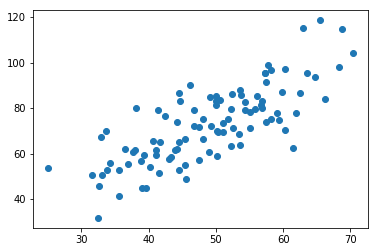

In [57]:
import csv

# Leemos la info de un archivo csv
with open('data.csv', 'r') as f:
  r = csv.reader(f)
  points = list(r)

# Separamos la información en trainX y trainY
# En trainX tenemos nuestros features. 
# En este ejemplo sólo tenemos un feature, metros cuadrados
# En trainY tenemos la variable que queremos predecir, en este caso
# el valor de la casa en miles de dólares.
trainX = []
trainY = []
for point in points:
    trainX.append(float(point[0])) 
    trainY.append(float(point[1]))
plt.scatter(trainX, trainY)

Ahora implementaremos el algoritmo de Gradient Descent.

Para comenzar, vamos a hacer una función que recibiendo el tamaño de la casa, el weight y el bias, podemos calcular el precio. Esto utiliza una ecuación de una línea recta (y = mx + b), pero para red neuronal.

In [3]:
#TODO: Implementa la función h(x) = w*x + b Función que predice costo de casa
def predict(size, weight, bias):
    """
    Función que predice el costo de una casa con una línea.
    
    Utiliza la función h(x) = x * w + b
    
    size: El tamaño de la casa en metros cuadrados
    weight: El peso asignado al tamaño de la casa
    bias: Para la regresión lineal, el valor predecido cuando el tamaño es 0.
    """
    return size * weight + bias

En la siguiente celda deberás implementar la función de pérdida de Mean Squared Error
![title](mse.png)
Recuerda utilizar la función predict (h) para hacer más sencillo el algoritmo. Adicionalmente, implementa las derivadas parciales respecto al peso y respecto al bias. **Omite el dos**. Dado que para la función de MSE agregamos una división entre dos, al derivar, se cancelará con el dos del exponente.
![title](mse_deriv.png)

In [69]:
#TODO: Implementa la función de pérdida y sus derivadas

def loss_function(sizes, costs, weight, bias):
    """
    Función que calcula el error de una propuesta de regresión lineal
    
    Utiliza la función h(x) = x * w + b
    
    sizes: Los tamaños de las casas en metros cuadrados.
    costs: Los costos verdaderos de las casas en cientos de miles de dólares.
    weight: El peso asignado al tamaño de la casa.
    bias: Para la regresión lineal, el valor predecido cuando el tamaño es 0.
    """
    totalError = 0
    m = len(sizes)
    
    # Calcula el error con diferencia de cuadrados
    for i in range(0, m):
        # ¿Cuál es el valor de entrada y cuál es el valor verdadero?
        x = sizes[i] 
        y = costs[i] 
        
        # ¿Qué valor predicen tus datos? Utiliza la función predict
        predicted = predict(x, weight, bias) 
        
        # Revisa la función para calcular el error
        totalError += (y - predicted) ** 2
        
    # Revisa la fórmula de MSE (Mean Squared Error)
    return totalError / (2 * float(m))


def loss_function_deriv_weight(size, cost, weight, bias, n):
    """
    Función que calcula la derivada parcial según el peso de MSE
    
    Utiliza la función h'(x) = (-1/n) * (y - (mx + b))
    
    size: El tamaño de una casa en metros cuadrados.
    cost: El costo real de la casa.
    weight: El peso asignado al tamaño de esa casa.
    bias: Para la regresión lineal, el valor predecido cuando el tamaño es 0.
    n: El tamaño del dataset.
    """
    return -(1/n) * size * (cost - predict(size, weight, bias))

def loss_function_deriv_bias(size, cost, weight, bias, n):
    """
    Función que calcula la derivada parcial según el bias de MSE
    
    Utiliza la función h'(x) = -1/n * (y - (mx + b))
    
    size: El tamaño de una casa en metros cuadrados.
    cost: El costo real de la casa.
    weight: El peso asignado al tamaño de esa casa.
    bias: Para la regresión lineal, el valor predecido cuando el tamaño es 0.
    n: El tamaño del dataset.
    """
    return -(1/n) * (cost - predict(size, weight, bias))

En la siguiente función implementaremos un algoritmo que ajusta el peso y el bias ligeramente minimizando el error. Para lograr esto, calculamos la derivada de la función de pérdida. Acumulamos estos valores y al final ajustamos ligeramente el peso y el bias. El ajuste se realiza de la siguiente manera

![title](gradient_step.png)

In [70]:
# TODO: Calcula el paso de gradient
def step_gradient(sizes, costs, weight, bias, learning_rate):
    """
    Función que propone un nuevo bias y peso que reduce la función de error.
    
    sizes: Los tamaños de la casa.
    cost: Los costos reales de la casa.
    weight: Los pesos de la casa.
    bias: Para la regresión lineal, el valor predecido cuando el tamaño es 0.
    learning_rate: Qué tan rápido va a aprender
    """
    
    # El valor acumulado de la derivada en diferentes puntos. Inicialmente es 0.
    weight_deriv = 0
    bias_deriv = 0
    
    # El tamaño del dataset
    m = float(len(sizes))
    
    # Para cada casa
    for i in range(len(sizes)):
        # ¿Cuál es su valor en X y en Y?
        x = sizes[i]
        y = costs[i]
        
        # Calcula las derivadas parciales del loss function
        bias_deriv += loss_function_deriv_bias(x, y, weight, bias, m)
        weight_deriv += loss_function_deriv_weight(x, y, weight, bias, m)
    
    # Da un paso en la dirección que minimice el error
    weight = weight - (weight_deriv * learning_rate)
    bias = bias - (learning_rate * bias_deriv)

    return weight, bias

Por último, vamos a crear una función que se encarga de entrenar el modelo utilizando Gradient Descent. Para cada epoch, vamos a realizar un step_gradient. 

In [71]:
# TODO: Entrena nuestro modelo con Gradient Descent
def train(sizes, costs, initial_weight, initial_bias, learning_rate, epoch):
    """
    Función que utiliza Gradient Descent para minimizar error.
    
    sizes: Los tamaños de la casa.
    cost: Los costos reales de la casa.
    intial_weight: El peso inicial del modelo.
    initial_bias: El bias inicial del modelo.
    learning_rate: Qué tan rápido va a aprender.
    epoch: Número de iteraciones sobre dataset.
    """
    weight = initial_weight
    bias = initial_bias
   
    # Itera varias veces sobre el dataset para minimizar el error
    for i in range(epoch):
        # Llama a step_gradient con sus argumentos correctos.
        weight, bias = step_gradient(sizes, costs, weight, bias, learning_rate)
        
        if i%10 == 0:
            print("Loss: ", str(loss_function(sizes, costs, weight, bias)), "b: " , bias, "w: ", weight)
    return weight, bias

En la siguiente celda definimos el peso y bias inicial. Adicionalmente, definimos el learning_rate y el número de epochs. Corre la celda para entrenar el modelo. La pérdida debería ser cercana a 56. Para comprobar resultados, revisa las siguientes celdas.

In [72]:
learning_rate = 0.0001
weight = 0.0
bias = 0.0
epochs = 100

weight, bias = train(trainX, trainY, bias, weight, learning_rate, epochs)
print(bias, weight)

Loss:  1593.1334591670343 b:  0.0072735050553686485 w:  0.3685351486795526
Loss:  61.304822885852516 b:  0.02815595150245868 w:  1.4157079689863437
Loss:  56.34127863702312 b:  0.02962799347020067 w:  1.4753104999490467
Loss:  56.32510567688096 b:  0.029995128482904965 w:  1.478697679083847
Loss:  56.32496327054147 b:  0.030299358309016006 w:  1.4788849183060186
Loss:  56.32487281343685 b:  0.030599996697912395 w:  1.47889000792012
Loss:  56.324782531451376 b:  0.03090041995985427 w:  1.4788847292628016
Loss:  56.32469225682516 b:  0.031200820284572717 w:  1.4788788606236802
Loss:  56.32460198901421 b:  0.03150120861246557 w:  1.4788729586112226
Loss:  56.3245117280162 b:  0.031801585566695316 w:  1.4788670549091827
0.032071915131595685 1.4788617416703924


Ahora que el modelo está entrenado (hemos definido un bias y un weight que describen el dataset), podemos predecir el valor de y para nuevos valores de x. En la siguiente celda utilizamos predict con el weight y bias definidos, y lo graficamos para ver si tiene sentido.

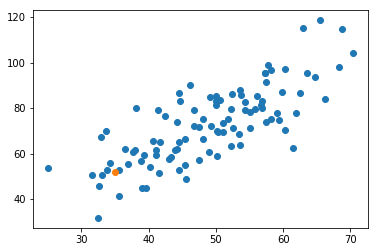

In [74]:
new_value = 35
predicted = predict(new_value, weight, bias)
plt.scatter(trainX, trainY)
plt.scatter(new_value, predicted)

En la siguiente celda haremos lo mismo pero para todos los puntos de 30 a 70.

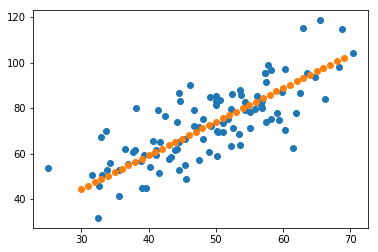

In [75]:
def plot(weight, bias):
    x = []
    y = []
    for i in range(30, 70):
        predicted = predict(i, weight, bias)
        x.append(i)
        y.append(predicted)
    plt.scatter(trainX, trainY)
    plt.scatter(x, y)
    
plot(weight, bias)

# Backpropagation

In [68]:
from numpy import *

# y = mx + b
# m is slope, b is y-intercept
def compute_error_for_line_given_points(b, m, points):
    totalError = 0
    for i in range(0, len(points)):
        x = points[i, 0]
        y = points[i, 1]
        totalError += (y - (m * x + b)) ** 2
    return totalError / float(len(points))

def step_gradient(b_current, m_current, points, learningRate):
    b_gradient = 0
    m_gradient = 0
    N = float(len(points))
    for i in range(0, len(points)):
        x = points[i, 0]
        y = points[i, 1]
        b_gradient += -(2/N) * (y - ((m_current * x) + b_current))
        m_gradient += -(2/N) * x * (y - ((m_current * x) + b_current))
    new_b = b_current - (learningRate * b_gradient)
    new_m = m_current - (learningRate * m_gradient)
    return [new_b, new_m]

def gradient_descent_runner(points, starting_b, starting_m, learning_rate, num_iterations):
    b = starting_b
    m = starting_m
    for i in range(num_iterations):
        b, m = step_gradient(b, m, array(points), learning_rate)
    return [b, m]

points = genfromtxt("data.csv", delimiter=",")
learning_rate = 0.0001
initial_b = 0 # initial y-intercept guess
initial_m = 0 # initial slope guess
num_iterations = 1000
[b, m] = gradient_descent_runner(points, initial_b, initial_m, learning_rate, num_iterations)
m

1.4777440851894448